In [1]:
!pip install -q papermill
!pip install -q matplotlib
!pip install -q networkx

In [2]:
import os
import tfx_utils
import tensorflow_data_validation as tfdv
%matplotlib notebook

In [3]:
def _make_default_sqlite_uri(pipeline_name):
    return os.path.join(os.environ['HOME'], 'datasets/metadata', pipeline_name, 'metadata.db')

def get_metadata_store(pipeline_name):
    return tfx_utils.TFXReadonlyMetadataStore.from_sqlite_db(_make_default_sqlite_uri(pipeline_name))

pipeline_name = 'simple_pipeline'

pipeline_db_path = _make_default_sqlite_uri(pipeline_name)
print('Pipeline DB:\n{}'.format(pipeline_db_path))

store = get_metadata_store(pipeline_name)

Pipeline DB:
/home/nikhilmehta/datasets/metadata/simple_pipeline/metadata.db


## ExampleGen Artifacts

In [4]:
# Visualize properties of example artifacts
store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.EXAMPLES)

,URI,SPLIT_NAMES,NAME,STATE,PRODUCER_COMPONENT,PIPELINE_NAME
ID,,,,,,
2,/home/nikhilmehta/datasets/CsvExampleGen/examp...,"[""train"", ""eval""]",examples,published,CsvExampleGen,simple_pipeline
6,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,published,Transform,simple_pipeline
19,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,published,Transform,simple_pipeline
22,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,published,Transform,simple_pipeline
25,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,-,Transform,simple_pipeline
27,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,published,Transform,simple_pipeline
30,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,published,Transform,simple_pipeline
35,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,-,Transform,simple_pipeline
37,/home/nikhilmehta/datasets/Transform/transform...,"[""train"", ""eval""]",transformed_examples,published,Transform,simple_pipeline


In [8]:
import pprint
import tensorflow as tf
pp = pprint.PrettyPrinter()

In [9]:
train_uri = '/home/nikhilmehta/datasets/CsvExampleGen/examples/1/train/'
# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

print (tfrecord_filenames)

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
    serialized_example = tfrecord.numpy()
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    pp.pprint(example)

['/home/nikhilmehta/datasets/CsvExampleGen/examples/1/train/data_tfrecord-00000-of-00002.gz', '/home/nikhilmehta/datasets/CsvExampleGen/examples/1/train/data_tfrecord-00001-of-00002.gz']
features {
  feature {
    key: "buying"
    value {
      bytes_list {
        value: "vhigh"
      }
    }
  }
  feature {
    key: "class"
    value {
      bytes_list {
        value: "unacc"
      }
    }
  }
  feature {
    key: "doors"
    value {
      bytes_list {
        value: "2"
      }
    }
  }
  feature {
    key: "lug_boot"
    value {
      bytes_list {
        value: "small"
      }
    }
  }
  feature {
    key: "maint"
    value {
      bytes_list {
        value: "vhigh"
      }
    }
  }
  feature {
    key: "persons"
    value {
      bytes_list {
        value: "2"
      }
    }
  }
  feature {
    key: "safety"
    value {
      bytes_list {
        value: "med"
      }
    }
  }
}

features {
  feature {
    key: "buying"
    value {
      bytes_list {
        value: "vhigh"


## StatsGen Artifacts

In [10]:
store.display_stats_for_examples(59)

<IPython.core.display.Javascript object>


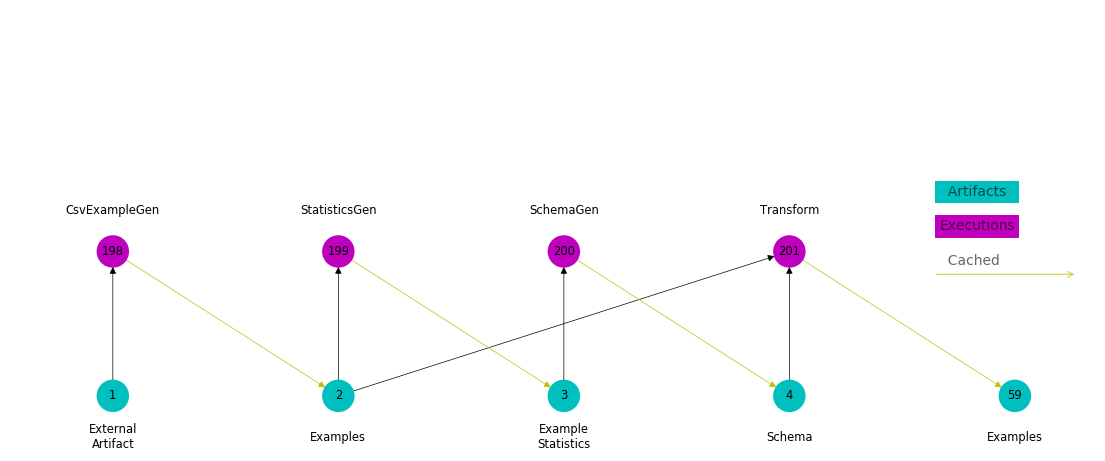

In [11]:
# Try different IDs here. Click stop in the plot when changing IDs.
store.plot_artifact_lineage(59)

## SchemaGen Artifcats

In [13]:
# Get the schema URI from the metadata store
schemas = store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.SCHEMA)
assert len(schemas.URI) == 1
schema_uri = schemas.URI.iloc[0] + '/schema.pbtxt'
print ('Schema URI:\n{}'.format(schema_uri))

Schema URI:
/home/nikhilmehta/datasets/SchemaGen/schema/3/schema.pbtxt


In [14]:
from tfx.utils import io_utils
from tensorflow_metadata.proto.v0 import schema_pb2

# For DatasetMetadata boilerplate
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import dataset_schema
from tensorflow_transform.tf_metadata import schema_utils

In [15]:
schema_proto = io_utils.parse_pbtxt_file(file_name=schema_uri, message=schema_pb2.Schema())
feature_spec, domains = schema_utils.schema_as_feature_spec(schema_proto)
legacy_metadata = dataset_metadata.DatasetMetadata(schema_utils.schema_from_feature_spec(feature_spec, domains))

In [16]:
# print (legacy_metadata)

In [17]:
type(schema_proto)

tensorflow_metadata.proto.v0.schema_pb2.Schema

In [18]:
type(domains)

dict

In [19]:
print (feature_spec)

{'doors': VarLenFeature(dtype=tf.string), 'safety': VarLenFeature(dtype=tf.string), 'persons': VarLenFeature(dtype=tf.string), 'buying': VarLenFeature(dtype=tf.string), 'maint': VarLenFeature(dtype=tf.string), 'lug_boot': VarLenFeature(dtype=tf.string), 'class': VarLenFeature(dtype=tf.string)}


In [20]:
domains['buying'].value

['high', 'low', 'med', 'vhigh']

In [21]:
# print (domains)

In [22]:
type(domains['buying'])

tensorflow_metadata.proto.v0.schema_pb2.StringDomain

In [23]:
feature_spec['buying'].dtype

tf.string

In [24]:
tfdv.display_schema(schema_proto)


,Type,Presence,Valency,Domain
Feature name,,,,
'doors',STRING,required,single,'doors'
'safety',STRING,required,single,'safety'
'persons',STRING,required,single,'persons'
'buying',STRING,required,single,'buying'
'maint',STRING,required,single,'maint'
'lug_boot',STRING,required,single,'lug_boot'
'class',STRING,required,single,'class'


,Values
Domain,
'doors',"'2', '3', '4', '5more'"
'safety',"'high', 'low', 'med'"
'persons',"'2', '4', 'more'"
'buying',"'high', 'low', 'med', 'vhigh'"
'maint',"'high', 'low', 'med', 'vhigh'"
'lug_boot',"'big', 'med', 'small'"
'class',"'acc', 'good', 'unacc', 'vgood'"


In [25]:
print (feature_spec)

{'doors': VarLenFeature(dtype=tf.string), 'safety': VarLenFeature(dtype=tf.string), 'persons': VarLenFeature(dtype=tf.string), 'buying': VarLenFeature(dtype=tf.string), 'maint': VarLenFeature(dtype=tf.string), 'lug_boot': VarLenFeature(dtype=tf.string), 'class': VarLenFeature(dtype=tf.string)}


In [26]:
from tensorflow_transform.tf_metadata import schema_utils

def get_raw_feature_spec(schema):
    return schema_utils.schema_as_feature_spec(schema).feature_spec

In [27]:
type(schema_proto)

tensorflow_metadata.proto.v0.schema_pb2.Schema

In [ ]:
# Transform

In [ ]:
tf_transform_output = tft.TFTransformOutput(transform_output)


In [39]:
# Training artifacts


,URI,PRODUCER_COMPONENT,PIPELINE_NAME,NAME,STATE
ID,,,,,
66,/home/nikhilmehta/datasets/Evaluator/evaluation/166,Evaluator,simple_pipeline,evaluation,-
68,/home/nikhilmehta/datasets/Evaluator/evaluation/175,Evaluator,simple_pipeline,evaluation,-
71,/home/nikhilmehta/datasets/Evaluator/evaluation/185,Evaluator,simple_pipeline,evaluation,-
74,/home/nikhilmehta/datasets/Evaluator/evaluation/196,Evaluator,simple_pipeline,evaluation,-
76,/home/nikhilmehta/datasets/Evaluator/evaluation/197,Evaluator,simple_pipeline,evaluation,-
78,/home/nikhilmehta/datasets/Evaluator/evaluation/203,Evaluator,simple_pipeline,evaluation,published


In [38]:
store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.MODEL)

,URI,PRODUCER_COMPONENT,PIPELINE_NAME,NAME,STATE
ID,,,,,
7,/home/nikhilmehta/datasets/Trainer/model/5,Trainer,simple_pipeline,model,-
8,/home/nikhilmehta/datasets/Trainer/model/10,Trainer,simple_pipeline,model,-
9,/home/nikhilmehta/datasets/Trainer/model/15,Trainer,simple_pipeline,model,-
10,/home/nikhilmehta/datasets/Trainer/model/20,Trainer,simple_pipeline,model,-
11,/home/nikhilmehta/datasets/Trainer/model/25,Trainer,simple_pipeline,model,-
12,/home/nikhilmehta/datasets/Trainer/model/30,Trainer,simple_pipeline,model,-
13,/home/nikhilmehta/datasets/Trainer/model/35,Trainer,simple_pipeline,model,-
14,/home/nikhilmehta/datasets/Trainer/model/40,Trainer,simple_pipeline,model,-
15,/home/nikhilmehta/datasets/Trainer/model/45,Trainer,simple_pipeline,model,-


In [ ]:
store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.MODEL)

In [40]:
store.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.MODEL_EVAL)

,URI,NAME,PRODUCER_COMPONENT,PIPELINE_NAME,STATE
ID,,,,,
66,/home/nikhilmehta/datasets/Evaluator/evaluation/166,evaluation,Evaluator,simple_pipeline,-
68,/home/nikhilmehta/datasets/Evaluator/evaluation/175,evaluation,Evaluator,simple_pipeline,-
71,/home/nikhilmehta/datasets/Evaluator/evaluation/185,evaluation,Evaluator,simple_pipeline,-
74,/home/nikhilmehta/datasets/Evaluator/evaluation/196,evaluation,Evaluator,simple_pipeline,-
76,/home/nikhilmehta/datasets/Evaluator/evaluation/197,evaluation,Evaluator,simple_pipeline,-
78,/home/nikhilmehta/datasets/Evaluator/evaluation/203,evaluation,Evaluator,simple_pipeline,published


<IPython.core.display.Javascript object>


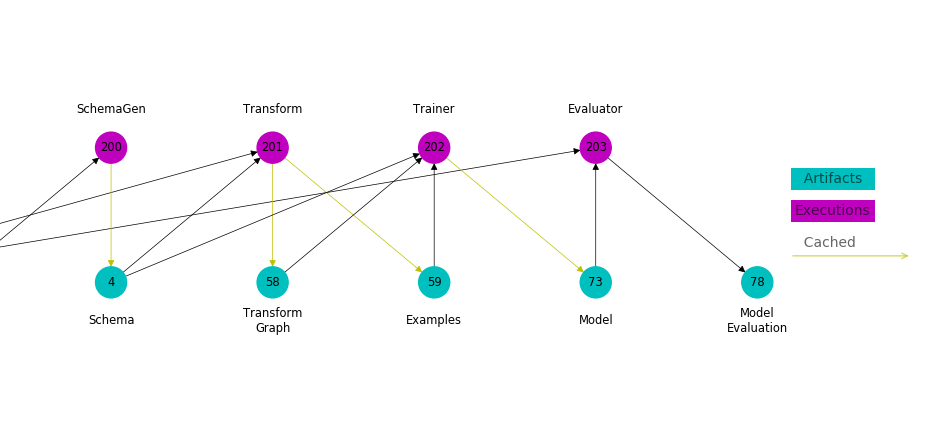

In [45]:
%matplotlib notebook
store.plot_artifact_lineage(78)

In [48]:
print (store.display_tfma_analysis(78))

None
